In [92]:
from bitcoin_listener import OrderBook
import bitcoin_listener as btcl

In [93]:
o = OrderBook(exchange='bitstamp')

In [94]:
o.fetch_one()

In [95]:
#o.flush_orderbook()

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline

In [97]:
# from list of dates read file
# read ask-bid-vol
# read ask-bid-orderbook til n/vol/...
# read ask-bid and estimate params
# save summary on database

In [98]:
#technical analysis

In [199]:
from bitcoin_listener import OrderBook
import os
import gzip
import numpy as np
import datetime as dt
import bitcoin_listener as btcl
source_orderbook = btcl.config['DEFAULT']['source_orderbook']


class Reader:
    
    def __init__(self, exchange):
        self.exchange = exchange
        self.dates = self.read_dates()

    def read_dates(self):
            
        if self.exchange not in OrderBook.EXCHANGES.keys():
            return []
        
        p = os.path.join(source_orderbook, self.exchange)
        
        return sorted([
            ".".join(f.split(".")[:-1]) for f in os.listdir(p)
            if os.path.isfile(os.path.join(p, f))
        ])

    def read_file(self, date):
        if self.exchange not in OrderBook.EXCHANGES.keys():
            return ""
        if date not in self.dates:
            return ""

        p = os.path.join(source_orderbook, self.exchange, "{}.gz".format(date))

        file_text = ""
        with gzip.open(p,'r') as gf: 
            file_text = gf.read().decode('utf-8')
        return file_text

    def get_orderbook(self, date, lim_orderbook=None):
        if self.exchange not in OrderBook.EXCHANGES.keys():
            return np.array([])
        if date not in read_dates(self.exchange):
            return np.array([])

        adj_price = OrderBook.EXCHANGES[self.exchange]['best_shift']['price']
        adj_amount = OrderBook.EXCHANGES[self.exchange]['best_shift']['amount']

        text = read_file(self.exchange, date)

        lines = [l for l in text.split('\n') if l]
        s = len(lines)

        data = np.ndarray(s, dtype=np.dtype([
                ('epoch', dt.datetime), 
                ('ask', np.dtype([('price', float),('qtd', 'uint')])), 
                ('bid', np.dtype([('price', float),('qtd', 'uint')])), 
                ('orderbook', np.dtype([('ask', np.ndarray),('bid', np.ndarray)]))
            ]))

        for i in range(s):

            d = lines[i].split('|')

            data[i]['epoch'] = dt.datetime.fromtimestamp(int(d[0]))

            qtd_askbid = [float(v) for v in d[1].split(' ')]
            data[i]['ask']['qtd'] = qtd_askbid[0]
            data[i]['bid']['qtd'] = qtd_askbid[1]

            list_asks = d[2].split(' ')[:lim_orderbook]
            oask = np.ndarray(len(list_asks), dtype=[('price', float), ('amount', float)])
            oask['price'] = np.cumsum([float(p.split(',')[0])/10**adj_price for p in list_asks])
            oask['amount'] = [float(p.split(',')[1])/10**adj_amount for p in list_asks]
            data[i]['ask']['price'] = oask['price'][0]
            data[i]['orderbook']['ask'] = oask

            list_bids = d[3].split(' ')[:lim_orderbook]
            obid = np.ndarray(len(list_bids), dtype=[('price', float), ('amount', float)])
            obid['price'] = np.cumsum([float(p.split(',')[0])/10**adj_price for p in list_bids])
            obid['amount'] = [float(p.split(',')[1])/10**adj_amount for p in list_bids]
            data[i]['bid']['price'] = obid['price'][0]
            data[i]['orderbook']['bid'] = obid

        return data
    
    def get(self, list_dates, lim_orderbook=None):
        list_data = []
        for date in list_dates:
            d = self.get_orderbook(date, lim_orderbook)
            if d.size>0:
                list_data.append(d)
        return np.concatenate(list_data) if len(list_data)>0 else np.array([])

In [228]:
r = Reader('bitstamp')
x = r.get_orderbook('2018-05-22', 5000)
y = r.get_orderbook('2018-05-23', 5000)
z = r.get(['2032-05-22','2018-05-22','2018-05-23'], 10000)

In [208]:
r.exchange, r.dates, x.size, y.size, z.size

('bitstamp',
 ['2018-05-20', '2018-05-21', '2018-05-22', '2018-05-23', '2018-05-24'],
 366,
 470,
 836)

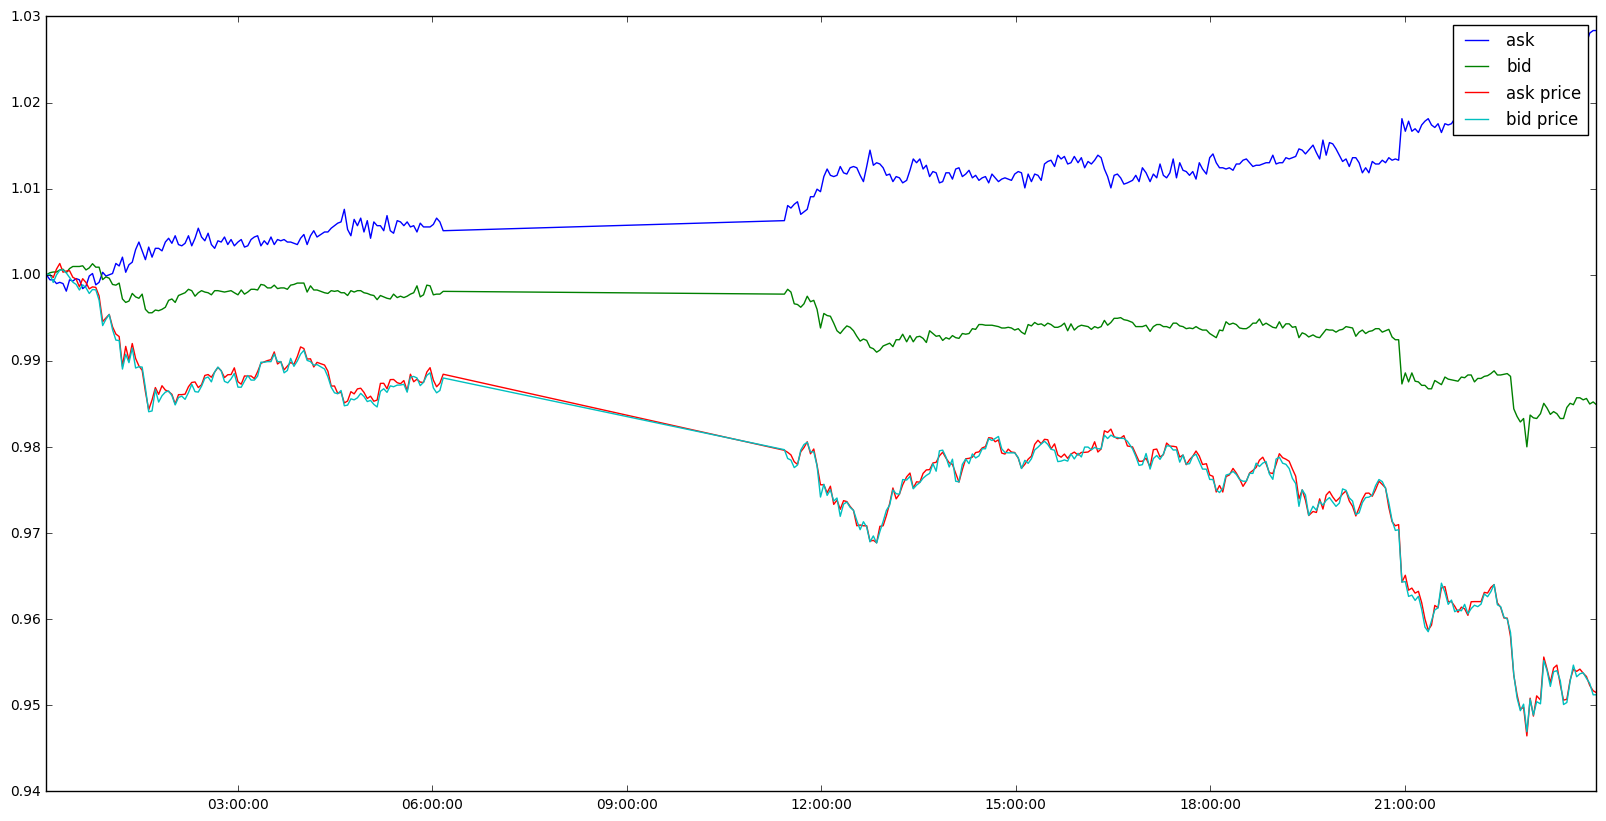

In [209]:
plt.figure(figsize=(20,10))
plt.plot(x['epoch'],x['ask']['qtd']/x['ask']['qtd'][0], label='ask')
plt.plot(x['epoch'],x['bid']['qtd']/x['bid']['qtd'][0], label='bid')
plt.plot(x['epoch'],x['ask']['price']/x['ask']['price'][0], label='ask price')
plt.plot(x['epoch'],x['bid']['price']/x['bid']['price'][0], label='bid price')
plt.legend()

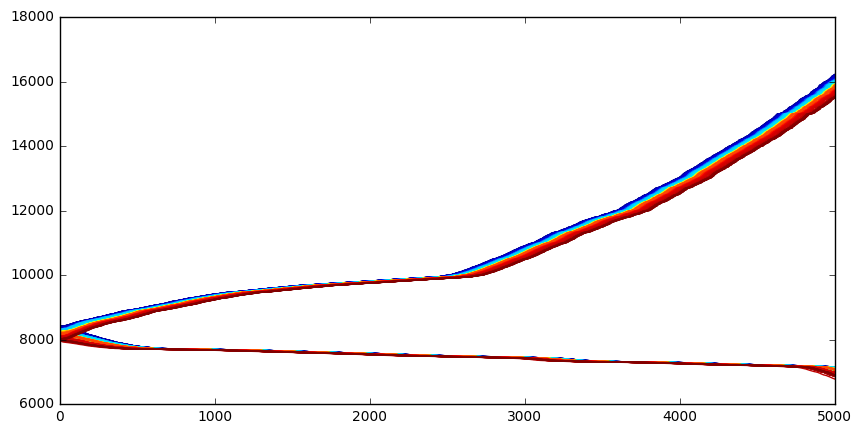

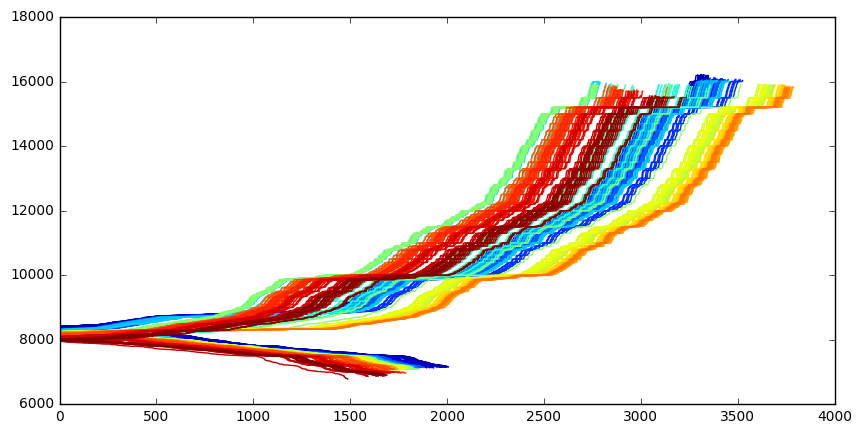

In [210]:
N = 0
X = x.size

hsv = plt.get_cmap('jet')
colors = hsv(np.linspace(0, 1.0, X))

plt.figure(figsize=(10,5))
for i in range(X-N):
    plt.plot(x[i+N]['orderbook']['ask']['price'], color=colors[i])
    plt.plot(x[i+N]['orderbook']['bid']['price'], color=colors[i])
plt.show()
plt.figure(figsize=(10,5))
for i in range(X-N):
    plt.plot(np.cumsum(x[i+N]['orderbook']['ask']['amount']),x[i+N]['orderbook']['ask']['price'], color=colors[i])
    plt.plot(np.cumsum(x[i+N]['orderbook']['bid']['amount']),x[i+N]['orderbook']['bid']['price'], color=colors[i])
plt.show()

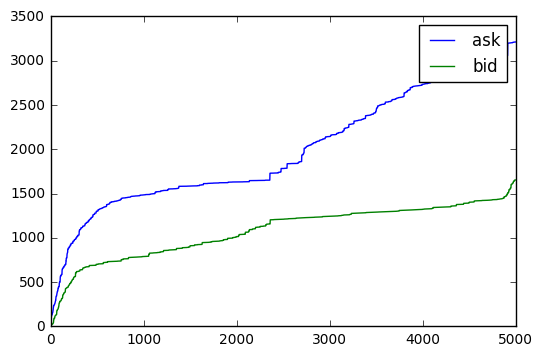

In [211]:
plt.plot(np.cumsum(x[i+N]['orderbook']['ask']['amount']), label='ask')
plt.plot(np.cumsum(x[i+N]['orderbook']['bid']['amount']), label='bid')
plt.legend()

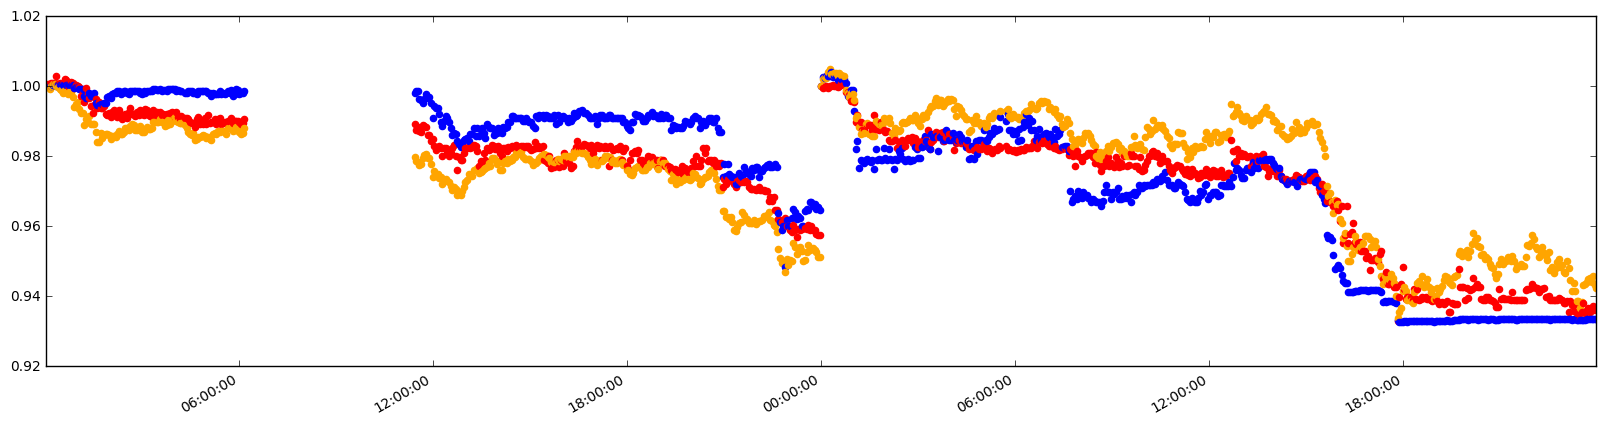

In [217]:
fig, ax = plt.subplots(figsize=(20,5))
fig.autofmt_xdate()
ax.set_xlim([x[0]['epoch'], y[-1]['epoch']])

X = x.size
for i in range(X):
    vx = x[i]['epoch']
    plt.scatter(x=vx, y=x[i]['orderbook']['ask']['price'][-1]/x[0]['orderbook']['ask']['price'][-1], color='red')
    plt.scatter(x=vx, y=x[i]['orderbook']['bid']['price'][-1]/x[0]['orderbook']['bid']['price'][-1], color='blue')
    plt.scatter(x=vx, y=x[i]['orderbook']['bid']['price'][0]/x[0]['orderbook']['bid']['price'][0], color='orange')
    
Y = y.size
for i in range(Y):
    vy = y[i]['epoch']
    plt.scatter(x=vy, y=y[i]['orderbook']['ask']['price'][-1]/y[0]['orderbook']['ask']['price'][-1], color='red')
    plt.scatter(x=vy, y=y[i]['orderbook']['bid']['price'][-1]/y[0]['orderbook']['bid']['price'][-1], color='blue')
    plt.scatter(x=vy, y=y[i]['orderbook']['bid']['price'][0]/y[0]['orderbook']['bid']['price'][0], color='orange')
plt.show()   

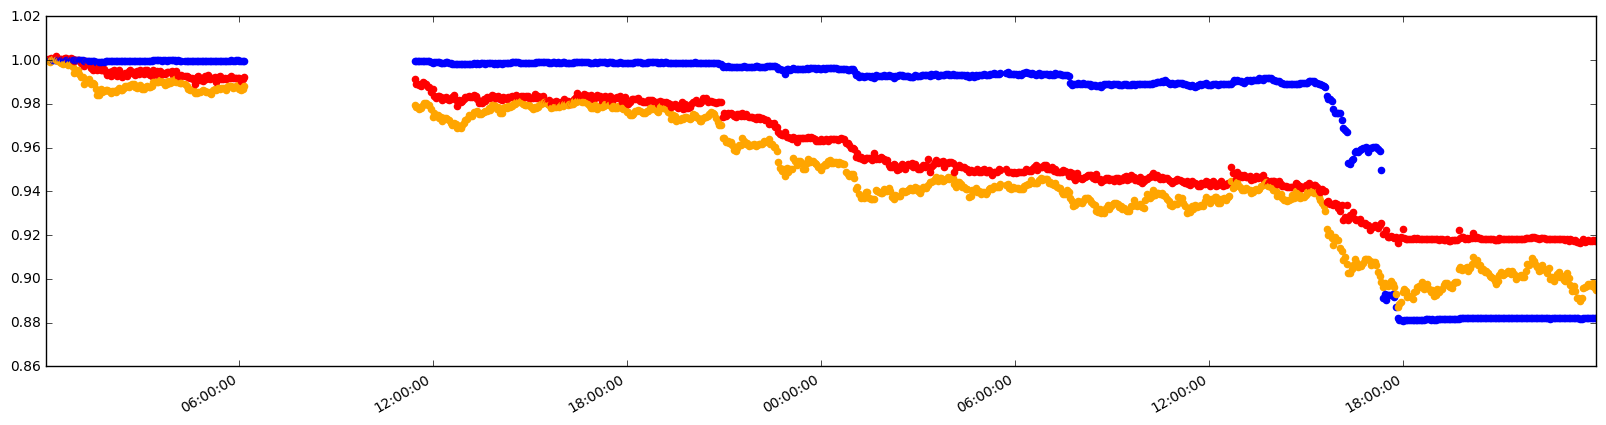

In [242]:
fig, ax = plt.subplots(figsize=(20,5))
fig.autofmt_xdate()
N = 3000
ax.set_xlim([z[0]['epoch'], z[-1]['epoch']])

Z = z.size
for i in range(Z):
    vz = z[i]['epoch']
    plt.scatter(x=vz, y=z[i]['orderbook']['ask']['price'][N]/z[0]['orderbook']['ask']['price'][N], color='red')
    plt.scatter(x=vz, y=z[i]['orderbook']['bid']['price'][N]/z[0]['orderbook']['bid']['price'][N], color='blue')
    plt.scatter(x=vz, y=z[i]['orderbook']['bid']['price'][0]/z[0]['orderbook']['bid']['price'][0], color='orange')
plt.show()

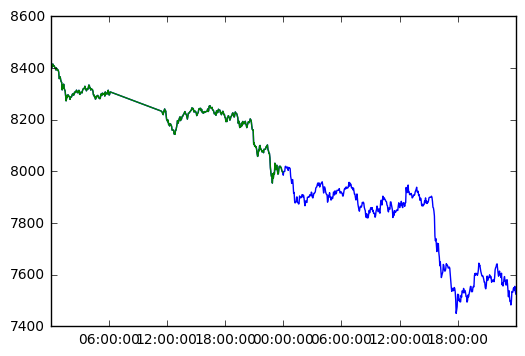

In [223]:
plt.plot(z['epoch'], z['ask']['price'])
plt.plot(x['epoch'], x['ask']['price'])